# FYP-DL: LogReg - Countering Imbalance via Class Weights
1. In this notebook, I'm going to use class weights to try and improve my model's ability to identify TP and TN examples over FP and FNs using class weights.

Specifically, I will test this with logistic regression.

In [ ]:
# For loading data from Drive
from google.colab import drive, files

# Standard Imports
import pandas as  pd
import os 
import numpy as np

# Sklearn - Model Selection
from sklearn.model_selection import RandomizedSearchCV, train_test_split 

# Sklearn - Model Evaluation 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, \
plot_confusion_matrix, plot_roc_curve

# Sklearn - Logistic Regression
from sklearn.linear_model import LogisticRegression

# Sklearn - Class Weights
from sklearn.utils.class_weight import compute_class_weight

# Random Number Seeding
np.random.seed(0)

In [ ]:
def get_classification_result(estimator, X, y_true, classifier_name=None,
                              normalize_conf_mat='all'):
    """Custom function to display classification results"""
    # Predictions will be used several times
    y_pred = estimator.predict(X) 

    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves'],))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    if (normalize_conf_mat=='rows'):
      normalize='true'
    elif (normalize_conf_mat=='cols'):
        normalize='pred'
    else:
      normalize=normalize_conf_mat

    # Use built-in function to get confusion matrix for this estimator
    conf_mat_display = plot_confusion_matrix(estimator=estimator, 
                                             X=X, 
                                             y_true=y_true, 
                                             labels=[0, 1],
                                             normalize=normalize, 
                                             display_labels=['Regular Consumers', 'Thieves'], 
                                             cmap=plt.cm.Blues)
    
    # Add a title (with optional classifier name)
    conf_mat_display.ax_.set_title("Confusion Matrix - {}".format(
        classifier_name if classifier_name is not None 
        else 'Test Classifier' ))
    
    # This will render the confusion matrix as an image
    print(conf_mat_display.confusion_matrix);
    plt.grid(False)       # Remove extra lines from confusion matrix

    roc_curve_display = plot_roc_curve(estimator, X, y_true)
    roc_curve_display.ax_.set_title('ROC Curve' +
                                    ('' if classifier_name is None else ' - {}'.format(classifier_name)), 
                                    fontsize=18);

#Import Modules

In [ ]:
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/pipelines.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/plot_utils.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/wdnn_transformers.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/build_WDNN.py"

#Loading Data


In [ ]:
# Mount Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Defining filepaths
ROOT_DIR = "/content/drive/My Drive"
FYP_DIR = "EE 16-17 FYP DL Energy Theft Detection"
DATA_DIR = "Data/full-processing-data"
FILE_NAME = "outliersRemoved.csv"

# Create filepath
FILE_PATH = os.path.join(ROOT_DIR, FYP_DIR, DATA_DIR, FILE_NAME)

In [ ]:
# Print the filepath for checking
print(FILE_PATH)

/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv


In [ ]:
# Read in the data
df = pd.read_csv(FILE_PATH)

In [ ]:
# Did it work 
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


In [ ]:
# Create independent and Dependent features
columns = df.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["FLAG"]]
# store the variable we are predicting
target = "FLAG"
# Define a random state
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
print(X.shape)
print(Y.shape)

(42372, 1035)
(42372,)


#Exploratory Data Analysis


In [ ]:
Thieves = df[df['FLAG']==1]

Regular_consumers = df[df['FLAG']==0]

In [ ]:
print(Thieves.shape,Regular_consumers.shape)

(3615, 1036) (38757, 1036)


#Train Test Split

In [ ]:
features, labels = df.iloc[:, 2:], df.iloc[:, 1]

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=labels.values)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  random_state=0, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val.values)

In [ ]:
print(X_train.shape, y_train.shape)

(27117, 1034) (27117,)


#Feature Scaling Pipeline

In [ ]:
# Import the pipeline functions from the pipeline modules
from pipelines import get_pipeline_1D, get_pipeline_2D

# Creating pipeline objects
pipeline_1D = get_pipeline_1D(scaling_strategy='Standard')

# Fit and then transform the pipelines to the training data first 
X_train_val_1D = pipeline_1D.fit_transform(X_train_val)
X_train_1D = pipeline_1D.fit_transform(X_train)
X_val_1D = pipeline_1D.fit_transform(X_val)
X_test_1D = pipeline_1D.fit_transform(X_test)

#Inspecting Feature Distributions

In [ ]:
from seaborn import distplot
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

def plot_feature_distributions(features, title_str=''):
  plt.figure(figsize=(12, 6))
  distplot(features.ravel(), kde=False, bins=100, hist_kws={'linewidth': 2, 'edgecolor': 'k'})
  plt.xlabel('Feature Values', fontsize=14)
  plt.ylabel('Frequency', fontsize=14)
  plt.title('Feature Distribution Plot' + title_str, fontsize=18)

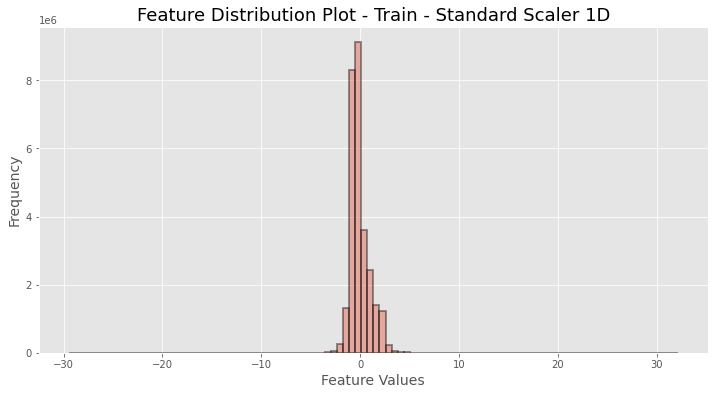

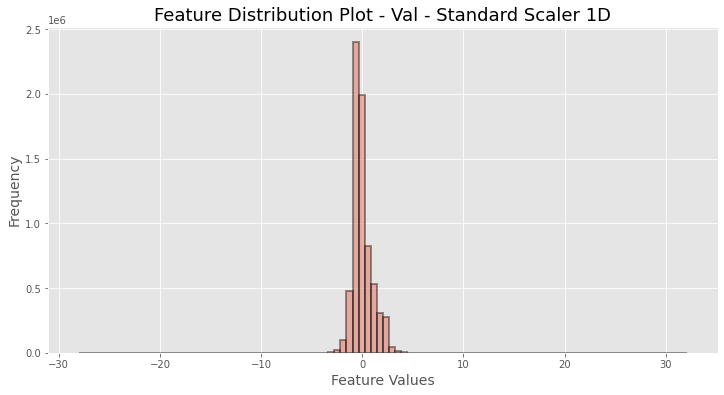

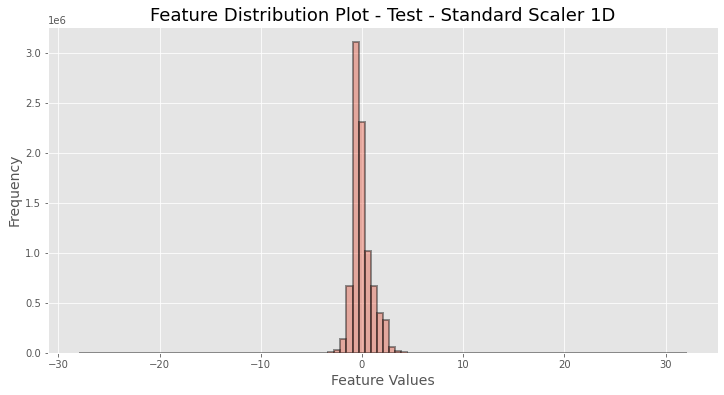

In [ ]:
plot_feature_distributions(X_train_1D, ' - Train - Standard Scaler 1D')
plot_feature_distributions(X_val_1D, ' - Val - Standard Scaler 1D')
plot_feature_distributions(X_test_1D, ' - Test - Standard Scaler 1D')

#Class Distribution**


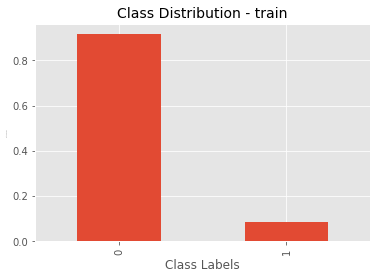

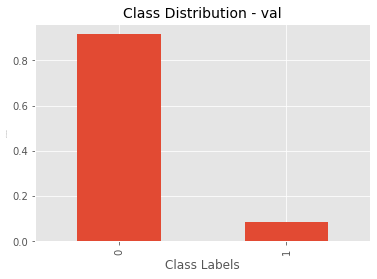

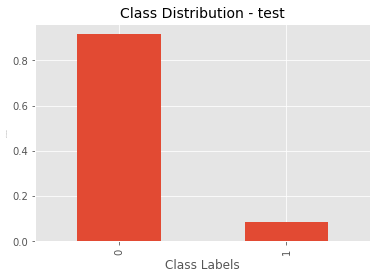

In [ ]:
for (name, y) in {'train': y_train, 'val': y_val, 'test': y_test}.items():
  plt.figure()
  df_tmp = pd.DataFrame(y)['FLAG'].value_counts(normalize=True)
  df_tmp.plot(kind='bar')
  plt.title('Class Distribution - ' + name, fontsize=14)
  plt.xlabel('Class Labels', fontsize=12)
  plt.ylabel('Pct of Samples', fontsize=1)

In [ ]:
print(X_train_val_1D.shape, y_train_val.shape)

(33897, 1034) (33897,)


#Class Weights 01 - sklearn API
1. Instead of figuring out a ratio of n_pos to n_neg manually and using them to set loss weights, I will use sklearn's compute_class_weight method.

2. I will be computing these weights using the train data, not train_val so as not to create a data leak.

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train_val
)

# Create a dictionary that can be passed to an `sklearn` estimator
cw_sklearn = dict(zip([0, 1], class_weights))

# Output this: does it make sense?
cw_sklearn

{0: 0.5466376390904693, 1: 5.860477178423237}

#Oversampling minority class (Thieves)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
os = RandomOverSampler(ratio=0.8)

In [ ]:
X.drop('CONS_NO', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_train_val_1D, y_train_val = os.fit_sample(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(X_train_val_1D.shape, y_train_val.shape)

(69762, 1034) (69762,)


In [ ]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_train_val)))

Original dataset shape Counter({0: 38757, 1: 3615})
Resampled dataset shape Counter({0: 38757, 1: 31005})


#Logistic Regression - Zheng

In [ ]:
# Instantiate
logRegZheng = LogisticRegression(penalty='l2', 
                                 C=1.0, 
                                 random_state=0, 
                                 class_weight=cw_sklearn, 
                                 max_iter=500, 
                                 verbose=1, 
                                 solver='liblinear')

# Fit to train_val_data - remember to use scaled data
logRegZheng.fit(X_train_val_1D, y_train_val)

[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0,
                   class_weight={0: 0.5466376390904693, 1: 5.860477178423237},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
                   verbose=1, warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       1.00      0.03      0.05      7752
         Thieves       0.09      1.00      0.16       723

        accuracy                           0.11      8475
       macro avg       0.54      0.51      0.11      8475
    weighted avg       0.92      0.11      0.06      8475

CONFUSION MATRIX
[[0.02618679 0.97381321]
 [0.00138313 0.99861687]]


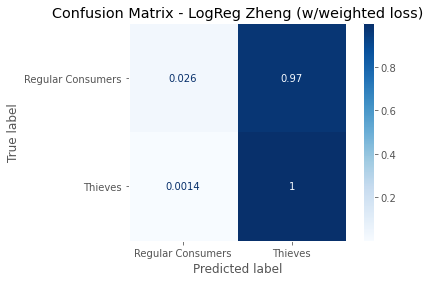

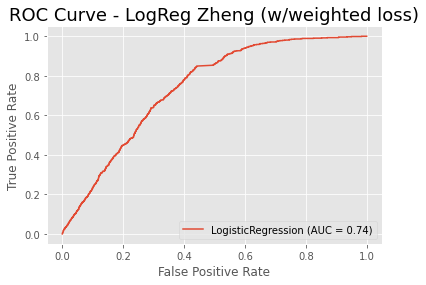

In [ ]:
# Did it do any better than the original model?
get_classification_result(estimator=logRegZheng, X=X_test_1D, 
                          y_true=y_test, 
                          classifier_name="LogReg Zheng (w/weighted loss)", 
                          normalize_conf_mat="rows")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       1.00      0.03      0.05      7752
         Thieves       0.09      1.00      0.16       723

        accuracy                           0.11      8475
       macro avg       0.54      0.51      0.11      8475
    weighted avg       0.92      0.11      0.06      8475

CONFUSION MATRIX
[[2.39528024e-02 8.90737463e-01]
 [1.17994100e-04 8.51917404e-02]]


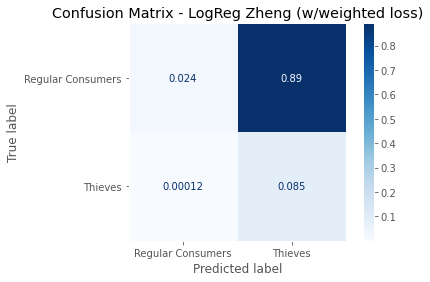

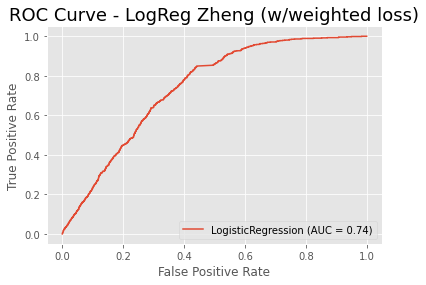

In [ ]:
# Did it do any better than the original model?
get_classification_result(estimator=logRegZheng, X=X_test_1D, 
                          y_true=y_test, 
                          classifier_name="LogReg Zheng (w/weighted loss)", 
                          normalize_conf_mat="all")

**How does this compare to the original model?**

In [ ]:
log_reg_zheng = LogisticRegression(penalty='l2', 
                                   C=1.0, 
                                   max_iter=500, 
                                   solver='liblinear', 
                                   random_state=0, 
                                   verbose=1)

In [ ]:
log_reg_zheng.fit(X_train_val_1D, y_train_val)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.26      0.02      0.04       723

        accuracy                           0.91      8475
       macro avg       0.59      0.51      0.50      8475
    weighted avg       0.86      0.91      0.88      8475

CONFUSION MATRIX
[[0.99406605 0.00593395]
 [0.97786999 0.02213001]]


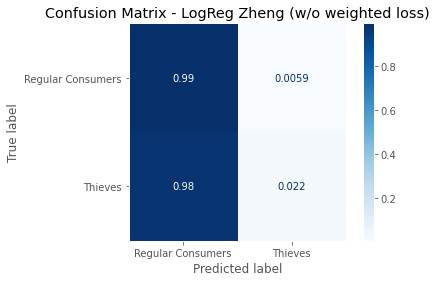

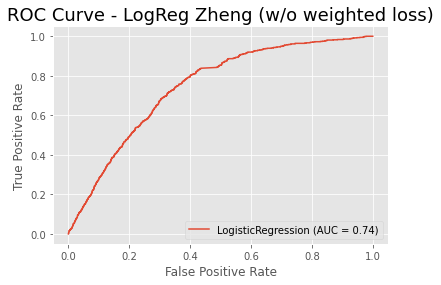

In [ ]:
get_classification_result(estimator=log_reg_zheng, 
                          X=X_test_1D, 
                          y_true=y_test, 
                          classifier_name="LogReg Zheng (w/o weighted loss)", 
                          normalize_conf_mat="rows")

#Manual Weights

In [ ]:
class_distribution = df['FLAG'].value_counts()/len(df)

In [ ]:
class_distribution

0    0.914684
1    0.085316
Name: FLAG, dtype: float64

In [ ]:
class_weights = dict(zip([0, 1], 1 / class_distribution))

In [ ]:
class_weights

{0: 1.0932734731790386, 1: 11.721161825726142}

In [ ]:
log_reg_manual = LogisticRegression(penalty='l2', 
                                    C=1.0, 
                                    class_weight=class_weights, 
                                    verbose=1, 
                                    solver='liblinear', 
                                    max_iter=500)

In [ ]:
log_reg_manual.fit(X_train_val_1D, y_train_val)

[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0,
                   class_weight={0: 1.0932734731790386, 1: 11.721161825726142},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='liblinear',
                   tol=0.0001, verbose=1, warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.99      0.02      0.04      7752
         Thieves       0.09      1.00      0.16       723

        accuracy                           0.11      8475
       macro avg       0.54      0.51      0.10      8475
    weighted avg       0.92      0.11      0.05      8475

CONFUSION MATRIX
[[0.02192982 0.97807018]
 [0.00138313 0.99861687]]


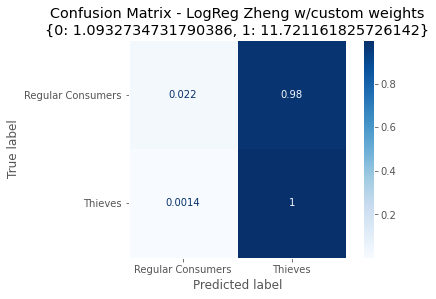

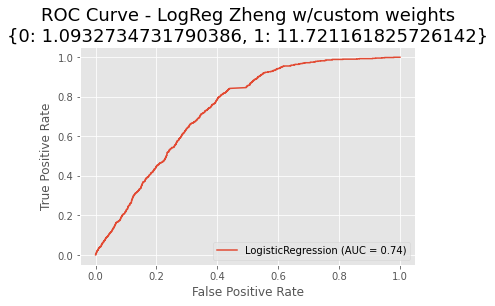

In [ ]:
get_classification_result(log_reg_manual, X_test_1D, y_test, 
                          classifier_name="LogReg Zheng w/custom weights\n" + 
                          str(class_weights), normalize_conf_mat="rows")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.99      0.02      0.04      7752
         Thieves       0.09      1.00      0.16       723

        accuracy                           0.11      8475
       macro avg       0.54      0.51      0.10      8475
    weighted avg       0.92      0.11      0.05      8475

CONFUSION MATRIX
[[2.00589971e-02 8.94631268e-01]
 [1.17994100e-04 8.51917404e-02]]


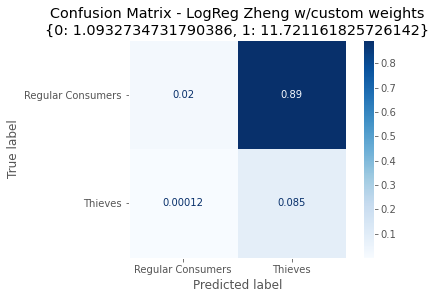

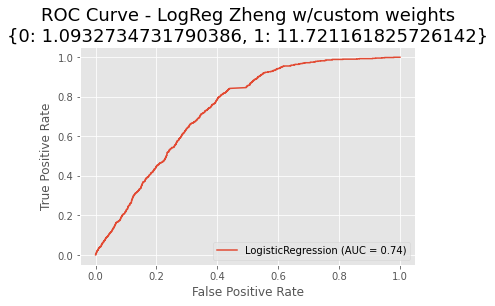

In [ ]:
get_classification_result(log_reg_manual, X_test_1D, y_test, 
                          classifier_name="LogReg Zheng w/custom weights\n" + 
                          str(class_weights), normalize_conf_mat="all")

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.99      0.02      0.04      7752
         Thieves       0.09      1.00      0.16       723

        accuracy                           0.11      8475
       macro avg       0.54      0.51      0.10      8475
    weighted avg       0.92      0.11      0.05      8475

CONFUSION MATRIX
[[0.99415205 0.91305395]
 [0.00584795 0.08694605]]


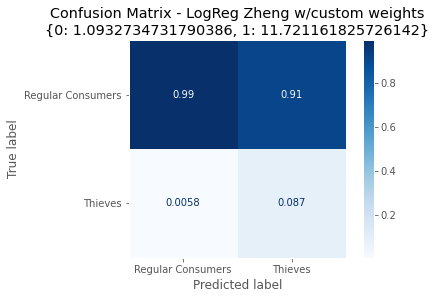

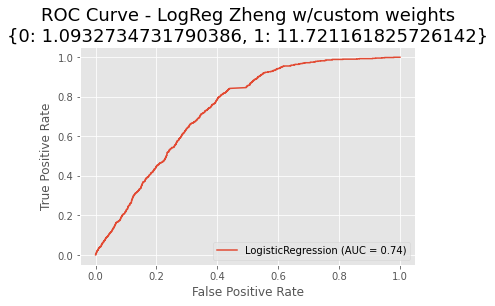

In [ ]:
get_classification_result(log_reg_manual, X_test_1D, y_test, 
                          classifier_name="LogReg Zheng w/custom weights\n" + 
                          str(class_weights), normalize_conf_mat="cols")